# ablation study
How accurate can we make a recurring timer in a linux server?

## pre-requisites

```sh
# python modules
pip install numpy matplotlib pandas
# system deps
sudo apt install curl build-essential
# rust
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
```
    

In [2]:
# compile userspace timer test
!cargo build --release

    Updating crates.io index
  Downloaded colorchoice v1.0.4                                            
  Downloaded anstyle-query v1.1.3                                          
  Downloaded clap_lex v0.7.5ng bytes: 1.8KiB                               
  Downloaded cfg-if v1.0.1ning bytes: 3.3KiB                               
  Downloaded anstyle-parse v0.2.7tes: 13.2KiB                              
  Downloaded anstream v0.6.19g bytes: 20.8KiB                              
  Downloaded anstyle v1.0.11                                               
  Downloaded is_terminal_polyfill v1.70.1.0KiB                             
  Downloaded utf8parse v0.2.2g bytes: 299.7KiB                             
  Downloaded once_cell v1.21.3 bytes: 253.8KiB                             
  Downloaded strsim v0.11.1ing bytes: 1.3MiB                               
  Downloaded crossbeam-deque v0.8.6s: 1.2MiB                               
  Downloaded crossbeam-utils v0.8.21 1.0MiB                

In [3]:
# stress test cpus
# run on system directly
#!stress-ng -l 50 -c 1 --cpu-method rand

In [4]:
subprocess.run(["perf", "stat", "--", program, "-r", f"{r}" , "-s", f"{interval}", "-a", f"{attempts}"], capture_output=True, text=True)

CompletedProcess(args=['perf', 'stat', '--', 'target/release/bpsleep', '-r', '0', '-s', '10', '-a', '10000'], returncode=255, stdout='', stderr='Error:\nNo permission to enable task-clock event.\n\n\n')

In [4]:
!python3 interval_accuracy.py

The results for an interval of 10 ns are: 
            avg      std        max      min        jit  cpu_cycles
0.000      74ns     44ns    4.227µs     64ns    4.163us   4,880,487
0.001  52.694µs  5.668µs  432.689µs  4.102µs  428.587us  11,072,382
0.010  52.692µs  4.139µs  162.397µs  4.276µs  158.121us  11,500,980
0.100  52.671µs  4.335µs  190.549µs  4.306µs  186.243us  11,941,009
0.200  52.592µs  3.868µs  167.345µs  4.358µs  162.987us  10,468,281
0.300  52.677µs  4.267µs  152.458µs  4.072µs  148.386us  11,161,200
0.400  52.665µs  4.205µs  158.066µs  4.074µs  153.992us  10,642,158
0.500  52.641µs  4.511µs  226.715µs  4.245µs   222.47us  11,090,863
0.600  52.686µs  4.657µs  174.629µs  4.275µs  170.354us  10,687,628
0.700  52.789µs  6.202µs  391.514µs  4.491µs  387.023us  10,973,604
0.800  52.584µs  4.005µs  167.117µs  4.212µs  162.905us  10,830,379
0.900  52.628µs  3.813µs  147.216µs  3.885µs  143.331us  10,758,181
1.000  52.575µs  2.336µs  125.223µs  4.069µs  121.154us  10,364,846
The r

## Plots

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


In [113]:
# fig, ax = plt.subplots()
# cxlnode_noload = pickle.load(open("", "rb"))

cxlnode_noload = pd.read_pickle("timer/results/cxlnode_10ns-1ms_noload.pkl")
cxlnode_20load = pd.read_pickle("timer/results/cxlnode_10ns-1ms_20load.pkl")
cxlnode_97load = pd.read_pickle("timer/results/cxlnode_10ns-1ms_97load.pkl")

number_of_runs = 1000
for i in cxlnode_noload:
    cxlnode_noload[i]["cpu_cycles"] = cxlnode_noload[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs
    
cxlnode_noload.pop(10000000) # remove the 10ms entry, not in other data sets 

for i in cxlnode_20load:
    cxlnode_20load[i]["cpu_cycles"] = cxlnode_20load[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs
    cxlnode_97load[i]["cpu_cycles"] = cxlnode_97load[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs


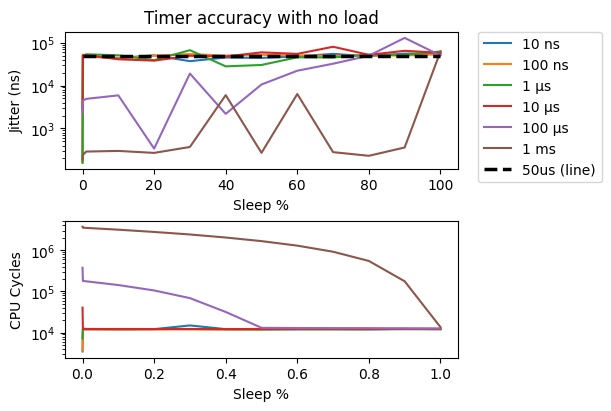

In [114]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

for interval in cxlnode_noload:
    axs[0].plot(cxlnode_noload[interval].index * 100, cxlnode_noload[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(cxlnode_noload[interval]["cpu_cycles"])

axs[0].plot(cxlnode_noload[10].index * 100, [50000]*len(cxlnode_noload[10].index), label="50us (line)", linestyle="--", color="black", linewidth=2.5)


axs[0].set_title("Timer accuracy with no load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")

axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

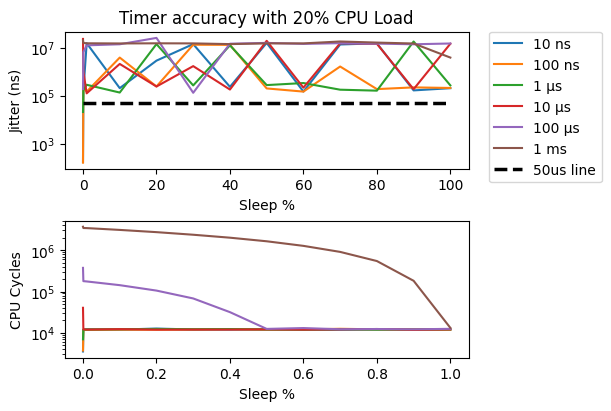

In [115]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

data = cxlnode_20load
for interval in data:
    axs[0].plot(data[interval].index * 100, data[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(data[interval]["cpu_cycles"])

axs[0].plot(data[10].index * 100, [50000]*len(data[10].index), label="50us line", linestyle="--", color="black", linewidth=2.5)

axs[0].set_title("Timer accuracy with 20% CPU Load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")

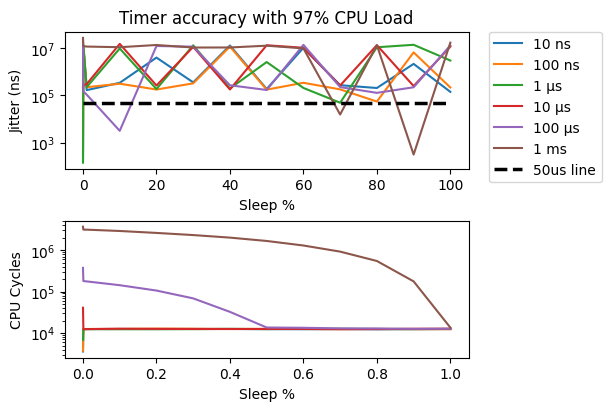

In [117]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

data = cxlnode_97load
for interval in data:
    axs[0].plot(data[interval].index * 100, data[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(data[interval]["cpu_cycles"])

axs[0].plot(data[10].index * 100, [50000]*len(data[10].index), label="50us line", linestyle="--", color="black", linewidth=2.5)

axs[0].set_title("Timer accuracy with 97% CPU Load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")

In [119]:
cxlnode_97load

{10:            avg       std         max      min         jit  cpu_cycles
 0.000    115.0       7.0       270.0    110.0       160.0    3588.392
 0.001  68108.0  408344.0  12970503.0  10770.0  12959733.0   12420.060
 0.010  55082.0    6165.0    177954.0   9100.0    168854.0   12465.576
 0.100  55099.0   10194.0    358448.0  12610.0    345838.0   12524.479
 0.200  59202.0  128122.0   4105066.0  23200.0   4081866.0   12502.052
 0.300  55147.0   10465.0    370859.0   9780.0    361079.0   12542.594
 0.400  68496.0  420518.0  13358962.0  13530.0  13345432.0   12541.369
 0.500  55178.0    6241.0    207355.0  19071.0    188284.0   12421.641
 0.600  65738.0  334359.0  10632029.0  18250.0  10613779.0   12345.595
 0.700  55131.0    8243.0    285087.0  11400.0    273687.0   12433.705
 0.800  55059.0    6966.0    213465.0   5250.0    208215.0   12319.945
 0.900  57248.0   68578.0   2215021.0  11530.0   2203491.0   12378.834
 1.000  55095.0    5523.0    149594.0   6800.0    142794.0   12480.982,
 